# Read stack of dm3 image files

This notebook reads a stack of **.dm3** microscopy images for analysis.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

# this is the library for reading the dm3 files
# install this using 'pip install ncempy'
from ncempy.io import dm

# these are custom methods in a .py file in the same directory
import microscopy_methods as mm

### Identify the image stack file

In [2]:
# identify the image stack filename
stack_filename = 'stack_pure_ZrO2-24%_25%_10_pics_each_26%_after_200us_1Hz.dm3'

# get full path of the image stack file
stack_path = os.path.join(os.getcwd(), stack_filename)

### Read the file

In [3]:
# read stack data
d = mm.read_stack(stack_path)

# examine the data
for key in d:
    print('{}: {}'.format(key, d[key]))

filename: stack_pure_ZrO2-24%_25%_10_pics_each_26%_after_200us_1Hz.dm3
data: [[[1127 1197 1230 ... 1749 1662 1651]
  [ 996 1095 1164 ... 1703 1642 1661]
  [1134 1127 1158 ... 1741 1708 1618]
  ...
  [1565 1786 1770 ... 1676 1726 1721]
  [1688 1869 1777 ... 1764 1722 1838]
  [1707 1824 1660 ... 1717 1684 1750]]

 [[1136 1067 1289 ... 1691 1762 1698]
  [1096 1118 1231 ... 1725 1463 1549]
  [1193 1234 1206 ... 1656 1557 1513]
  ...
  [1491 1498 1473 ... 1570 1616 1491]
  [1534 1564 1524 ... 1711 1560 1491]
  [1711 1654 1567 ... 1658 1547 1483]]

 [[1570 1553 1651 ... 1602 1679 1633]
  [1815 1645 1679 ... 1653 1737 1750]
  [1781 1682 1705 ... 1722 1694 1741]
  ...
  [1796 1693 1608 ... 1449 1411 1465]
  [1792 1680 1564 ... 1604 1426 1316]
  [1604 1591 1493 ... 1616 1546 1515]]

 ...

 [[1377 1533 1604 ... 1407 1474 1680]
  [1309 1381 1454 ... 1410 1435 1597]
  [1273 1295 1311 ... 1567 1580 1556]
  ...
  [1425 1528 1531 ... 1689 1647 1635]
  [1512 1721 1587 ... 1538 1660 1677]
  [1642 1721 

### Create sliding window for image analysis

In [4]:
# set size in pixels of sliding window to sample and oversample
samples = 15
oversamples = 25

# get index slices for sampled and oversampled windows
img = d['data'][0,:,:]
slices = mm.get_window_slices(img, samples, oversamples)
print('Created {} sampling windows across {} pixel image'.format(
    len(slices['s']), img.shape))

Created 18769 sampling windows across (2048, 2048) pixel image


### Apply sliding window for image analysis

C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


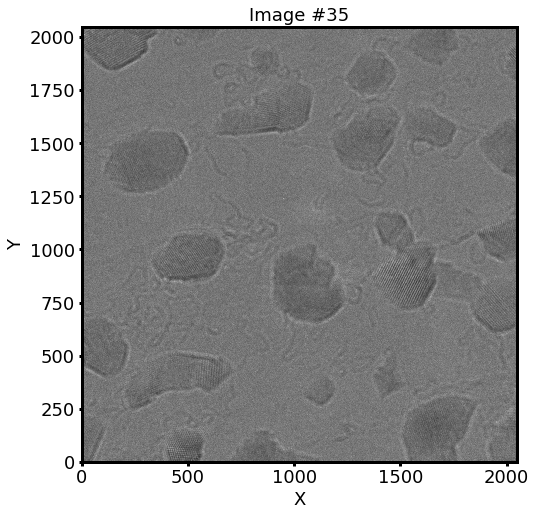

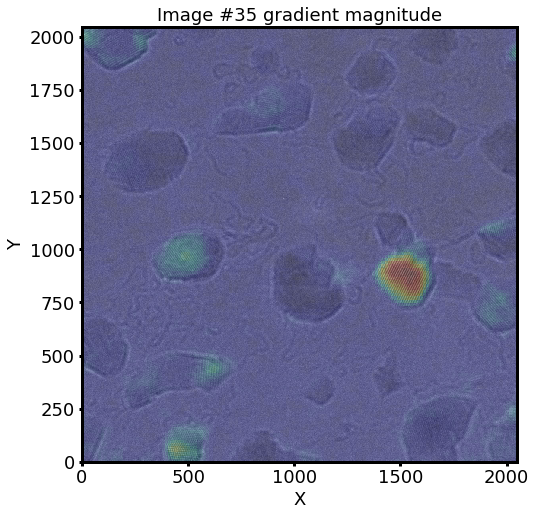

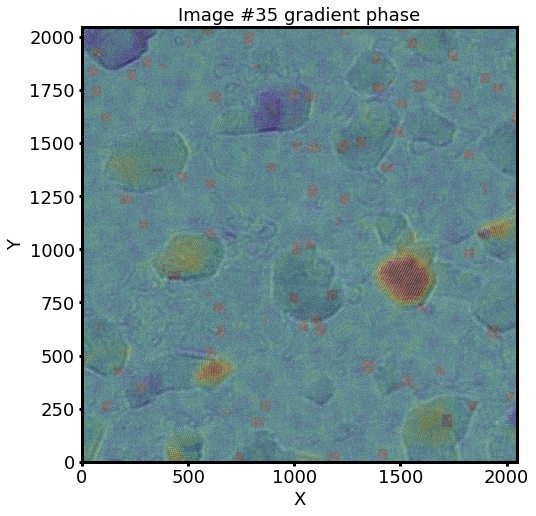

In [5]:
def get_gradient_info(img):
    """Get magnitude and phase of gradient of 2D image."""
    grad_x, grad_y = np.abs(np.gradient(img))
    grad_mag = np.mean(np.hypot(grad_x, grad_y))
    grad_phase = np.mean(np.arctan(grad_y/grad_x))
    return grad_mag, grad_phase
    
def map_image(img, slices):
    """Create maps of an image using a sliding window."""
    layers = {
        'gradient_mag': np.zeros_like(img),
        'gradient_phase': np.zeros_like(img),
    }
    
    # loop over each sliding window
    for w in range(len(slices['s'])):
        
        # get oversampled window
        osw = img[slices['os'][w]]
        
        # get statistics of oversampled window
        gradient_mag, gradient_phase = get_gradient_info(osw)

        # get slice of sampled window
        sw = slices['s'][w]
        
        # save statistics of sampled image window
        layers['gradient_mag'][sw] = gradient_mag
        layers['gradient_phase'][sw] = gradient_phase

    return layers


# loop over specified images in the image stack
for i in range(35, d['data'].shape[0], 12):
    
    # selet the image and normalize its intensity from 0 to 1
    img = d['data'][i, :, :]
    img = mm.norm_image(img)

    
    # create dictionary of calculated image layers to overlay on original image
    layers = map_image(img, slices)
    
    # plot the raw image
    plt.imshow(img, extent=d['span'], origin='lower', cmap='gray')
    mm.plot_setup(title='Image #{}'.format(i))
    plt.show()
    

    # plot magnitude of the local gradient
    plt.imshow(img, extent=d['span'], origin='lower', cmap='gray')
    plt.imshow(layers['gradient_mag'], origin='lower', cmap='jet', alpha=0.2)
    mm.plot_setup(title='Image #{} gradient magnitude'.format(i))
    plt.show()
    
    # plot the local gradient angle
    plt.imshow(img, extent=d['span'], origin='lower', cmap='gray')
    plt.imshow(layers['gradient_phase'], origin='lower', cmap='jet', alpha=0.2)
    mm.plot_setup(title='Image #{} gradient phase'.format(i))
    plt.show()
    

In [6]:
#blobs = blob_dog(1-img, min_sigma=100, max_sigma=300, threshold=.1)

In [7]:
'''
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.imshow(img)

for blob in blobs:
    y, x, r = blob
    
    #r *= np.sqrt(2)
    
    c = plt.Circle((x, y), r, linewidth=1, fill=False)
    ax.add_patch(c)
    plt.text(x, y, str(int(r)))

mm.plot_setup()
plt.show()

print(len(blobs))
'''

'\nfig = plt.figure()\nax = fig.add_subplot(1, 1, 1)\n\nplt.imshow(img)\n\nfor blob in blobs:\n    y, x, r = blob\n    \n    #r *= np.sqrt(2)\n    \n    c = plt.Circle((x, y), r, linewidth=1, fill=False)\n    ax.add_patch(c)\n    plt.text(x, y, str(int(r)))\n\nmm.plot_setup()\nplt.show()\n\nprint(len(blobs))\n'

In [8]:
'''
edges = cv2.Canny(img.astype('uint8'), 0, .01)
print(np.any(edges))
print(len(np.where(edges==255)[0]))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis(False)

plt.subplot(122)
plt.imshow(edges)#, cmap='gray')
plt.title('Edge Image')
plt.axis(False)
plt.show()
'''

"\nedges = cv2.Canny(img.astype('uint8'), 0, .01)\nprint(np.any(edges))\nprint(len(np.where(edges==255)[0]))\n\nplt.subplot(121)\nplt.imshow(img, cmap='gray')\nplt.title('Original Image')\nplt.axis(False)\n\nplt.subplot(122)\nplt.imshow(edges)#, cmap='gray')\nplt.title('Edge Image')\nplt.axis(False)\nplt.show()\n"

In [9]:
'''
from skimage.feature import canny
canny_edges = canny(
    img,
    sigma=0.7,
    low_threshold=0.1,
    high_threshold=0.7)

plt.imshow(canny_edges, origin='lower')

plt.show()


print(np.any(canny_edges))
'''

"\nfrom skimage.feature import canny\ncanny_edges = canny(\n    img,\n    sigma=0.7,\n    low_threshold=0.1,\n    high_threshold=0.7)\n\nplt.imshow(canny_edges, origin='lower')\n\nplt.show()\n\n\nprint(np.any(canny_edges))\n"

In [10]:
'''
grad_mag = np.hypot(grad_x, grad_y)

plt.imshow(grad_mag, cmap='jet')#, vmin=grad_mag.min(), vmax=grad_mag.max())
plt.colorbar()
plt.plot()
'''

"\ngrad_mag = np.hypot(grad_x, grad_y)\n\nplt.imshow(grad_mag, cmap='jet')#, vmin=grad_mag.min(), vmax=grad_mag.max())\nplt.colorbar()\nplt.plot()\n"